In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  
import sys
BASE_PATH = os.path.join(
   '/home/tzhouaq/ManGO_MOO/'
)
sys.path.append(BASE_PATH)
sys.path.append(os.path.join(BASE_PATH, 'off_moo_baselines'))
import logging
import numpy as np
import torch
from matplotlib import pyplot as plt
import pandas as pd 
import datetime 
import json 
import copy
import wandb
CONDITIONAL_TASKS = []
 
import off_moo_bench as ob
from mango_utliz import save_uncon_results, plot_scatter, plot_line,  save_indicators, get_best_result, get_device
from end2end_diffusion.SDE import DiffusionMOO
from utils import set_seed
from off_moo_baselines.end2end.nets import End2EndMultiHeadModel
from off_moo_baselines.end2end.trainer import get_trainer
from off_moo_baselines.end2end.surrogate_problem import End2EndSurrogateProblem
from off_moo_baselines.data import tkwargs, get_dataloader
from off_moo_bench.task_set import *
 

Auto Configuration Succeed!, Using database /home/tzhouaq/ManGO_MOO/off_moo_bench/problem/mo_nas/database.
Configuration Succeed!
Auto Configuration Succeed!, Using database /home/tzhouaq/ManGO_MOO/off_moo_bench/problem/mo_nas/database.


/home/tzhouaq/anaconda3/envs/mango4moo/lib/python3.8/site-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


/home/tzhouaq/ManGO_MOO/off_moo_bench/problem/lambo/data/experiments/test/regex_problem.pkl


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
# toy example
# te1 

# Synthetic Functions 
# "dtlz1 dtlz2 dtlz3 dtlz4 dtlz5 dtlz6 dtlz7 omnitest omnitest omnitest omnitest omnitest vlmop1 vlmop2 vlmop3 omnitest"

# RE
# "omnitest omnitest omnitest omnitest omnitest omnitest omnitest re33 omnitest omnitest omnitest omnitest re41 omnitest re61"

# MO-NAS
# "nb201_test c10mop1 c10mop2 c10mop3 c10mop4 c10mop5 c10mop6 c10mop7 c10mop8 c10mop9 in1kmop1 in1kmop2 in1kmop3 in1kmop4 in1kmop5 in1kmop6 in1kmop7 in1kmop8 in1kmop9"

# MORL
# "mo_hopper_v2 mo_swimmer_v2"

# MOCO 
# "bi_tsp_20 bi_tsp_50 bi_tsp_100 bi_tsp_500 tri_tsp_20 tri_tsp_50 tri_tsp_100 bi_cvrp_20 bi_cvrp_50 bi_cvrp_100 bi_kp_50 bi_kp_100 bi_kp_200"

# Scientific Design
# "zinc regex rfp molecule"

In [3]:
from utils import process_args 
sys.argv = ['--model=End2End', '--train_mode=Vallina','--task=omnitest','--use_wandb=False','--n_epochs=10','--retrain_model=False','--seed=1000']
config = process_args(return_dict=True)

results_dir = os.path.join('/home/tzhouaq/ManGO_MOO/', "results")
model_save_dir = os.path.join('/home/tzhouaq/ManGO_MOO/', "model")
 
config["results_dir"] = results_dir
config["model_save_dir"] = model_save_dir
config["data_pruning"] = True
config['data_preserved_ratio']= 1.0
config['hidden_size']=2048
config['inverse_lr']=1e-4
# config['batch_size']= 16
config['inverse_lr_decay']=0.98
config['n_epochs']= 200

config['simple_clip']=True
config['debais']=True
config["record_hist"]=False
config['dropout']=0. 
config['augment']=True
config['condition_training']=False
config['model_ckpt'] = None 
# config['normalize_xs'] = False
# config['normalize_ys'] = False

All config: {'results_dir': './results', 'model_save_dir': './model', 'use_wandb': False, 'run_type': 'train', 'seed': 1000, 'retrain_model': False, 'num_solutions': 256, 'solver_n_gen': 50, 'solver_init_method': 'nds', 'model': 'End2End', 'train_mode': 'Vallina', 'task': 'omnitest', 'n_epochs': 10, 'data_pruning': False, 'batch_size': 128, 'forward_lr': 0.001, 'forward_lr_decay': 0.98, 'normalize_xs': True, 'normalize_ys': True, 'to_logits': False, 'record_hist': True}


In [4]:
# initialise task
if config["task"] in ALLTASKSDICT.keys():
    config["task"] = ALLTASKSDICT[config["task"]]

results_dir = os.path.join(config['results_dir'], 
                            f"{config['model']}-{config['train_mode']}-{config['task']}")
config["results_dir"] = results_dir 

ts = datetime.datetime.utcnow() + datetime.timedelta(hours=+8)
ts_name = f"-ts-{ts.year}-{ts.month}-{ts.day}_{ts.hour}-{ts.minute}-{ts.second}"
run_name = f"Ours-{config['model']}-{config['train_mode']}-seed{config['seed']}-{config['task']}"

logging_dir = os.path.join(config['results_dir'], run_name + ts_name)
os.makedirs(logging_dir, exist_ok=True)

if config['use_wandb']:
    if 'wandb_api' in config.keys():
        wandb.login(key=config['wandb_api'])

    wandb.init(
        project="ManGO_MOO",
        name=run_name + ts_name,
        config=config,
        group=f"{config['model']}-{config['train_mode']}",
        job_type=config['run_type'],
        mode="online",
        dir=os.path.join(config['results_dir'], '..')
    )

with open(os.path.join(logging_dir, "params.json"), "w") as f:
    json.dump(config, f, indent=4)

set_seed(config['seed'])
os.environ["SEED"] = f"{config['seed']}"

task = ob.make(config['task'])
# dataset_dic = {"dataset_max_percentile": 0.25, "dataset_min_percentile": 0} #取[1-dataset_max_percentile,1-dataset_min_percentile]区位的数据
# task = ob.make(config['task'],dataset_kwargs=dataset_dic, subsample=True)
# task.y.shape
x_min, x_max, y_min, y_max = task.dataset.get_xy_min_max()
x_lbound = x_min#task.problem.xl
x_ubound = x_max#task.problem.xu
print('x_min:', x_min, '\n', 'x_max:',x_max, '\n','y_min:',y_min,'\n', 'y_max:',y_max)
print('x_lbound:', x_lbound, '\n', 'x_ubound:',x_ubound)


x_min: [2.30898310e-05 2.71458458e-05] 
 x_max: [5.9999421  5.99999092] 
 y_min: [-1.99999552 -1.999992  ] 
 y_max: [1.9996544  1.99987381]
x_lbound: [2.30898310e-05 2.71458458e-05] 
 x_ubound: [5.9999421  5.99999092]


In [5]:
#There are some issues with the normalization implemented by benchmark. Here, let's avoid them to obtaine X and Y directly.
X = task.x.copy()
y = task.y.copy()
 
X_test = copy.deepcopy(task.x_test)
y_test = copy.deepcopy(task.y_test)
len_data = task.x.shape[0]
 
if config["data_pruning"]:
    X, y = task.get_N_non_dominated_solutions(
        N=int(len_data * config["data_preserved_ratio"]),
        return_x=True, return_y=True
    )

if config['to_logits']:
    assert task.is_discrete 
    task.map_to_logits()
    X = task.to_logits(X)
    X_test = task.to_logits(X_test)
if config['normalize_xs']:
    task.map_normalize_x()
    # X = copy.deepcopy(X)
    X = task.normalize_x(X)
    X_test = task.normalize_x(X_test)
    x_lbound = task.normalize_x(x_lbound)
    x_ubound = task.normalize_x(x_ubound)
    x_min = task.normalize_x(x_min)
    x_max = task.normalize_x(x_max)
pf = task.problem.get_pareto_front() 
if config['normalize_ys']:
    task.map_normalize_y()
    y = task.normalize_y(y)
    y_test = task.normalize_y(y_test)
    pf = task.normalize_y(pf)
    y_min = task.normalize_y(y_min)
    y_max = task.normalize_y(y_max)

 
if config['to_logits']:
    data_size, n_dim, n_classes = tuple(X.shape)
    X = X.reshape(-1, n_dim * n_classes)
    X_test = X_test.reshape(-1, n_dim * n_classes)
else:
    data_size, n_dim = tuple(X.shape)
n_obj = y.shape[1]

X.shape, y.shape, X_test.shape, y_test.shape


((60000, 2), (60000, 2), (40000, 2), (40000, 2))

In [6]:
#This cell is to train or load the forward model
config['retrain_model']=False
config['n_epochs']= 200
config['batch_size']= 32
config["train_mode"] = "gradnorm"
config["gradient_alpha"] = 0.12
model_save_dir = config['model_save_dir']
config["weight_lr"] = 5e-4
config['weight_lr_decay']=0.99
model_save_dir = config['model_save_dir']
os.makedirs(model_save_dir, exist_ok=True)

model_save_path = os.path.join(
    model_save_dir,
    f"{config['model']}-{config['train_mode']}-{config['task']}-{config['seed']}.pt"
)
model = End2EndMultiHeadModel(
    n_dim=n_dim * n_classes if config['to_logits'] else n_dim,
    n_obj=n_obj,
    hidden_size=[2048, 2048],
    save_path=model_save_path,
).to(**tkwargs)

trainer_func = get_trainer(config["train_mode"])

trainer = trainer_func(
    forward_model=model, 
    config=config
)

(
    train_loader,
    val_loader,
    test_loader
) = get_dataloader(X, y, X_test, y_test,
                    val_ratio=0.01,
                    batch_size=config["batch_size"])

trainer.launch(
    train_loader,
    val_loader,
    test_loader,
    retrain_model=config["retrain_model"]
)


#attain the surrogate problem
surrogate_problem = End2EndSurrogateProblem(
    n_var=n_dim * n_classes if config['to_logits'] else n_dim, n_obj=n_obj, model=model
)

Successfully load trained model from /home/tzhouaq/ManGO_MOO/model/End2End-gradnorm-OmniTest-Exact-v0-1000.pt with valid MSE = 0.055076997727155685


In [7]:
from end2end_diffusion.mango_training import mango_train

print(config['inverse_lr'])
CONDITIONAL_TASKS = []
# torch.set_default_dtype(torch.float32)
 
if config['augment']:

    clip_min = torch.tensor(np.concatenate((x_lbound, y_min)))
    clip_max = torch.tensor(np.concatenate((x_ubound, y_max)))
else:
    clip_min = torch.tensor(x_min)
    clip_max = torch.tensor(x_max)

clip_dic = {'simple_clip': config['simple_clip'], 'clip_min': clip_min , 'clip_max': clip_max}
print(clip_dic)


try:
    inverse_model
except NameError:
    inverse_model = None

# inverse_model = None
# config['n_epochs']=400
# # # # # clip_dic['simple_clip']=True
# inverse_model = mango_train(
#     task=task,
#     X=X,
#     y=y,
#     forward_model=model,
#     inverse_model=inverse_model,
#     hidden_size=config['hidden_size'],
#     lr=config['inverse_lr'],
#     dropout=config['dropout'],
#     device='auto',
#     seed=config['seed'],
#     num_epochs= config['n_epochs'],
#     ckpt_dir=config['model_save_dir'],
#     score_matching=True,
#     # data_preserved_ratio=config['data_preserved_ratio'],  
#     clip_dic=clip_dic,
#     # debais=config['debais'],
#     augment=config['augment'],
#     condition_training=config['condition_training']
# )


0.0001
{'simple_clip': True, 'clip_min': tensor([0., 0., 0., 0.], dtype=torch.float64), 'clip_max': tensor([1., 1., 1., 1.], dtype=torch.float64)}


In [8]:
# load the pretrained model
model_ckpt = '/home/tzhouaq/ManGO_MOO/model/ours-omnitest-seed1000-hidden2048-score_matchingTrue.ckpt' #e=1000, 0.2*full data

inverse_model = DiffusionMOO.load_from_checkpoint(
    model_ckpt,
    taskname=task.dataset_name,
    task=task,
    learning_rate=config['inverse_lr'],
    dropout_p=config['dropout'],
    hidden_size=config['hidden_size'],
    simple_clip=clip_dic['simple_clip'],
    clip_min= clip_dic['clip_min'],
    clip_max= clip_dic['clip_max'],
    debais=config['debais'],
    augment=config['augment'],
    forwardmodel=model,
    condition_training=False
)


uncondition_training T: {1.0}


{'simple_clip': True, 'clip_min': tensor([0., 0., 0., 0.], dtype=torch.float64), 'clip_max': tensor([1., 1., 1., 1.], dtype=torch.float64)}
Hypervolume (100th): 4.466293
Ideal Hypervolume: 4.840578
L2 dist between design score and given y: 2.850747418242173
L2 dist between generated and given y: 3.6272004816287766
Best design is: 
 [0.59107196 0.2634935  0.05286534 0.6533639 ]
Best design score is: 
 [0.01069787 0.59925961]
Best design score in training set: 
 [0.01653723 0.62486824]
Oracle design score is: 
 [-1.11993121e-06 -2.00127612e-06]
Distance between the best to oracle value in training set is :
 0.6250890639694294
Distance between the best to oracle value is :
 0.5993571139692836
Hypervolume (100th): 4.470704
Hypervolume (75th): 4.432057
Hypervolume (50th): 4.373695
Hypervolume (D(best)): 4.528378
Ideal Hypervolume: 4.840578
GD: 0.1796200173200806
GD+: 9.070323383608247e-06
IGD: 0.11873370763371634
IGD+: 0.05355959259910723


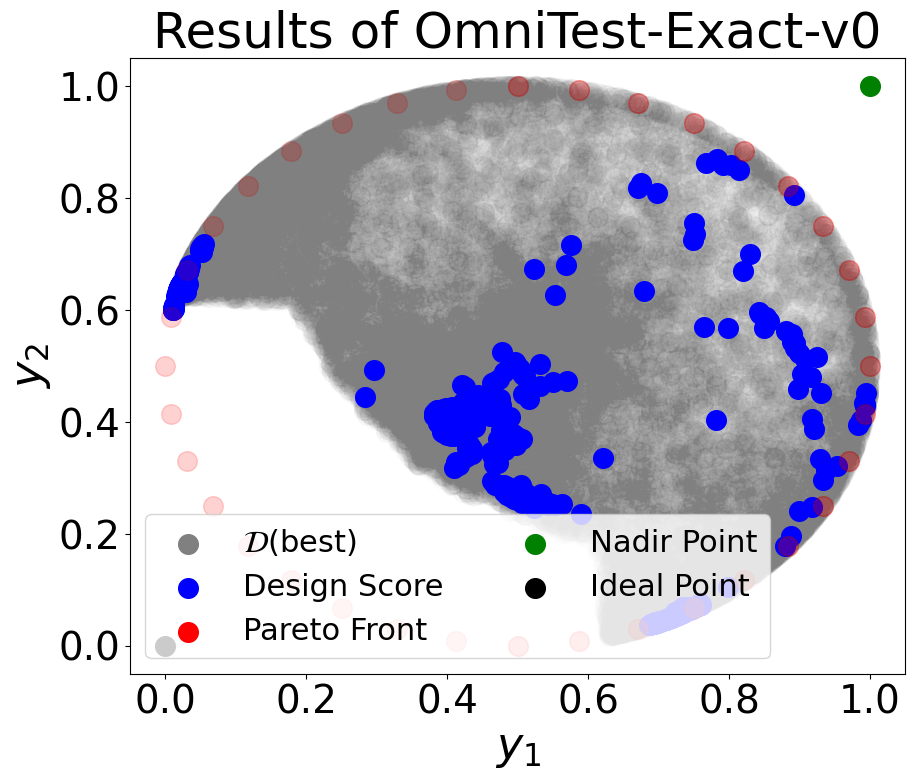

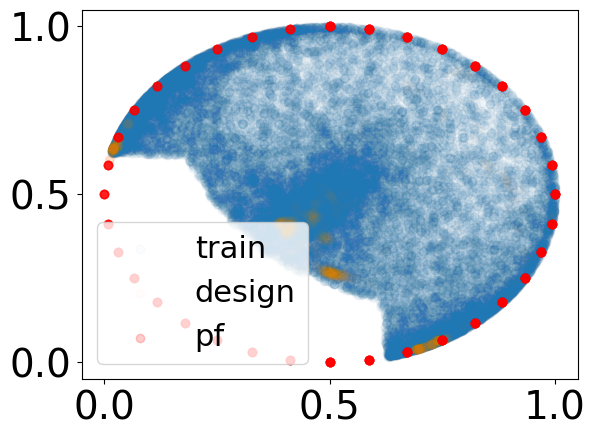

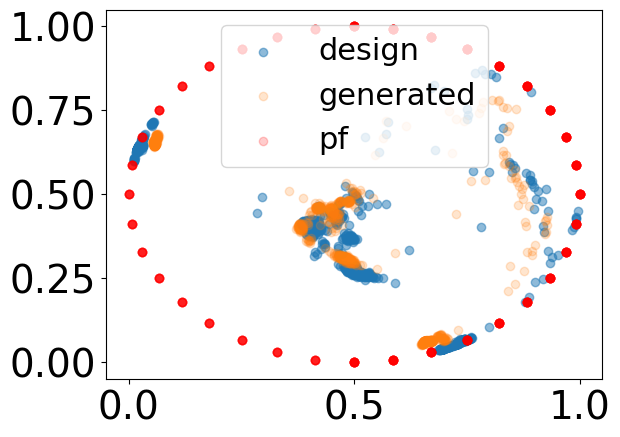

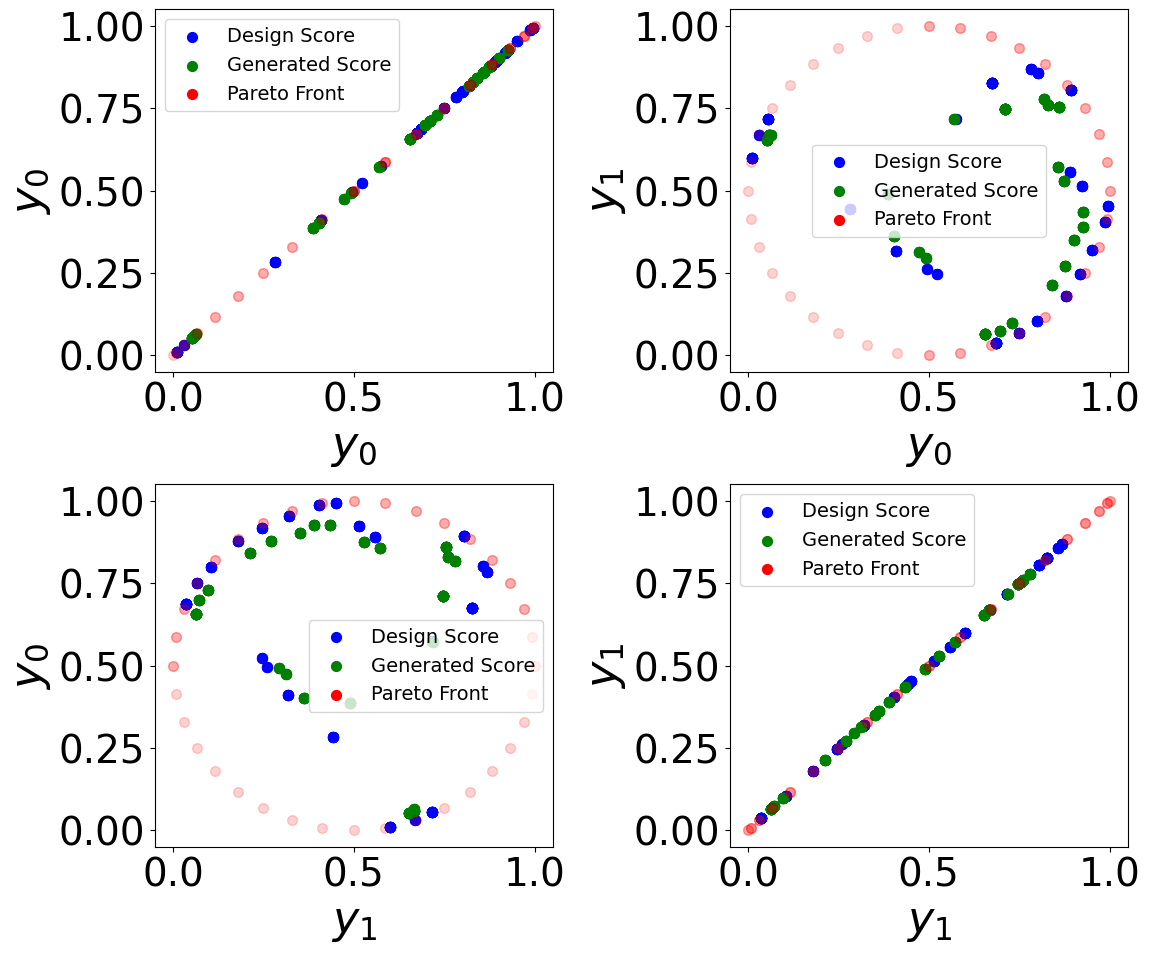

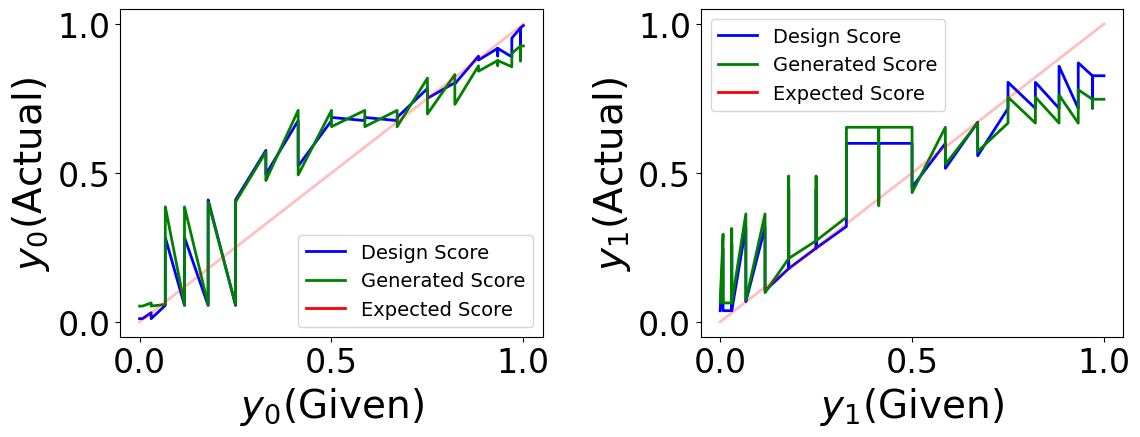

In [9]:
#This cell is to conduct unconditional generation 
from end2end_diffusion.mango_eval_fks import mango_eval, fixed_random_seed

if config['augment']:
    pf = task.problem.get_pareto_front() 
    if config['normalize_ys']:
        pf = task.normalize_y(pf)
    y_min = np.minimum(y_min, pf.min(axis=0))
    y_max = np.maximum(y_max, pf.max(axis=0))
    clip_min = torch.tensor(np.concatenate((x_min, y_min)))#x_lbound
    clip_max = torch.tensor(np.concatenate((x_max, y_max)))#x_ubound
else:
    clip_min = torch.tensor(x_min)
    clip_max = torch.tensor(x_max)
print(clip_dic)

num_samples = 1000
 
res = mango_eval(
    task=task,
    forwardmodel=model,
    inverse_model=inverse_model,
    device='auto',
    num_samples=num_samples,
    # seed=config['seed'],
    logging_dir=logging_dir,
    ckpt_dir=config['model_save_dir'],
    augment=config['augment'],
    clip_dic=clip_dic,
    condition_training=config['condition_training'],
    # gen_condition=y_given,
    num_steps=1000
    # guidance=True
)

res_x, res_y, y_cand, y_gen, y_given_list = save_uncon_results(res, task, config, model, logging_dir, X, y)

pf = task.problem.get_pareto_front()
if config['normalize_ys']:
    pf = task.normalize_y(pf)

plt.scatter(y[:,0],y[:,1],label='train',alpha=0.02)
plt.scatter(res_y[:,0],res_y[:,1],label='design',alpha=0.02)
# plt.scatter(y_test[:,0],y_test[:,1],label='test',alpha=0.02)
plt.scatter(pf[:,0],pf[:,1],label='pf',color='r',alpha=0.2)
plt.legend()
plt.show()
y_dim = task.y.shape[-1]
plt.scatter(res_y[:,0],res_y[:,1],label='design',alpha=0.5)
plt.scatter(res_x[:,-y_dim],res_x[:,-(y_dim-1)],label='generated',alpha=0.2)
plt.scatter(pf[:,0],pf[:,1],label='pf',color='r',alpha=0.2)
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.legend()

#plot scatter and line
description = 'uncond'
kkk = 100
seed = 42
plot_scatter(y_cand, y_gen, y_given_list, description, logging_dir, kkk, seed)
plot_line(y_cand, y_gen, y_given_list, description, logging_dir, kkk, seed)
 

{'simple_clip': True, 'clip_min': tensor([0., 0., 0., 0.], dtype=torch.float64), 'clip_max': tensor([1., 1., 1., 1.], dtype=torch.float64)}
{'simple_clip': True, 'clip_min': tensor([ 0.0000e+00,  0.0000e+00, -1.1199e-06, -2.0013e-06],
       dtype=torch.float64), 'clip_max': tensor([1.0000, 1.0000, 1.0001, 1.0000], dtype=torch.float64)}
****************************************Seed: 40*********************************************************


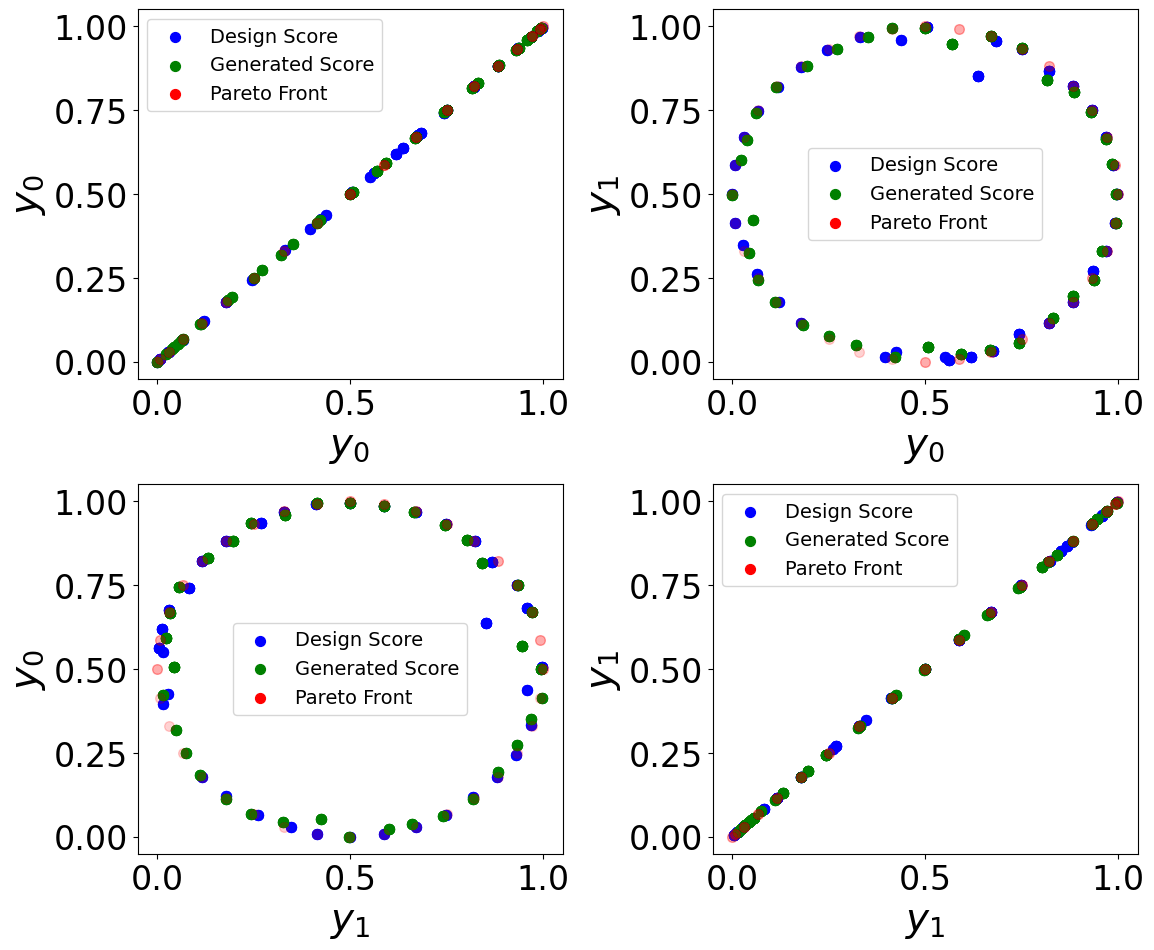

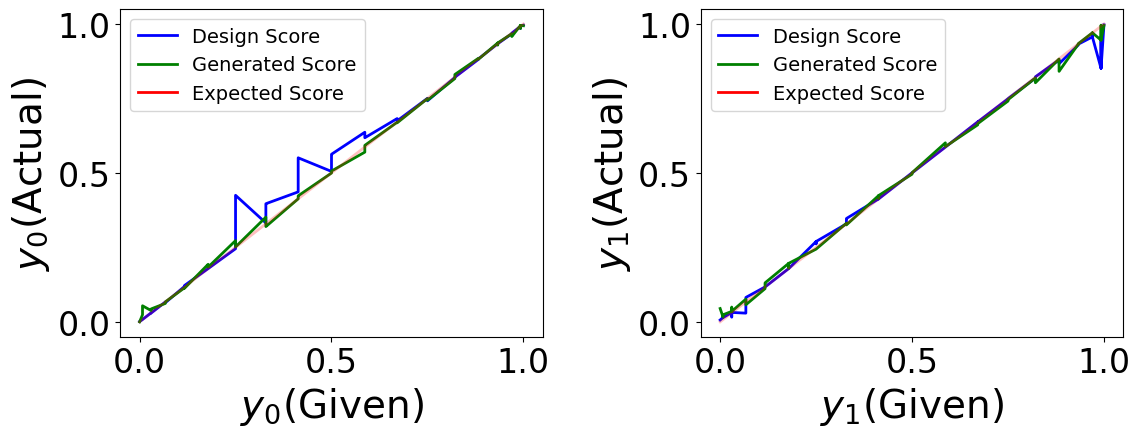

Hypervolume (100th): 4.750660
Hypervolume (D(best)): 13.264787
Ideal Hypervolume: 4.840578
y_given Hypervolume: 4.774988
pf Hypervolume: 4.774988
GD: 0.013352353559838895
GD+: 0.000650817264912229
IGD: 0.01432432992752446
IGD+: 0.0035085964244156664
L2 dist between design score and given y: 0.8588280893079813
L2 dist between generated and given y: 0.38826996485452464
Spread for y_cand: 1.784218699480601
Spread for y_gen: 1.7873450784248939
****************************************Seed: 41*********************************************************


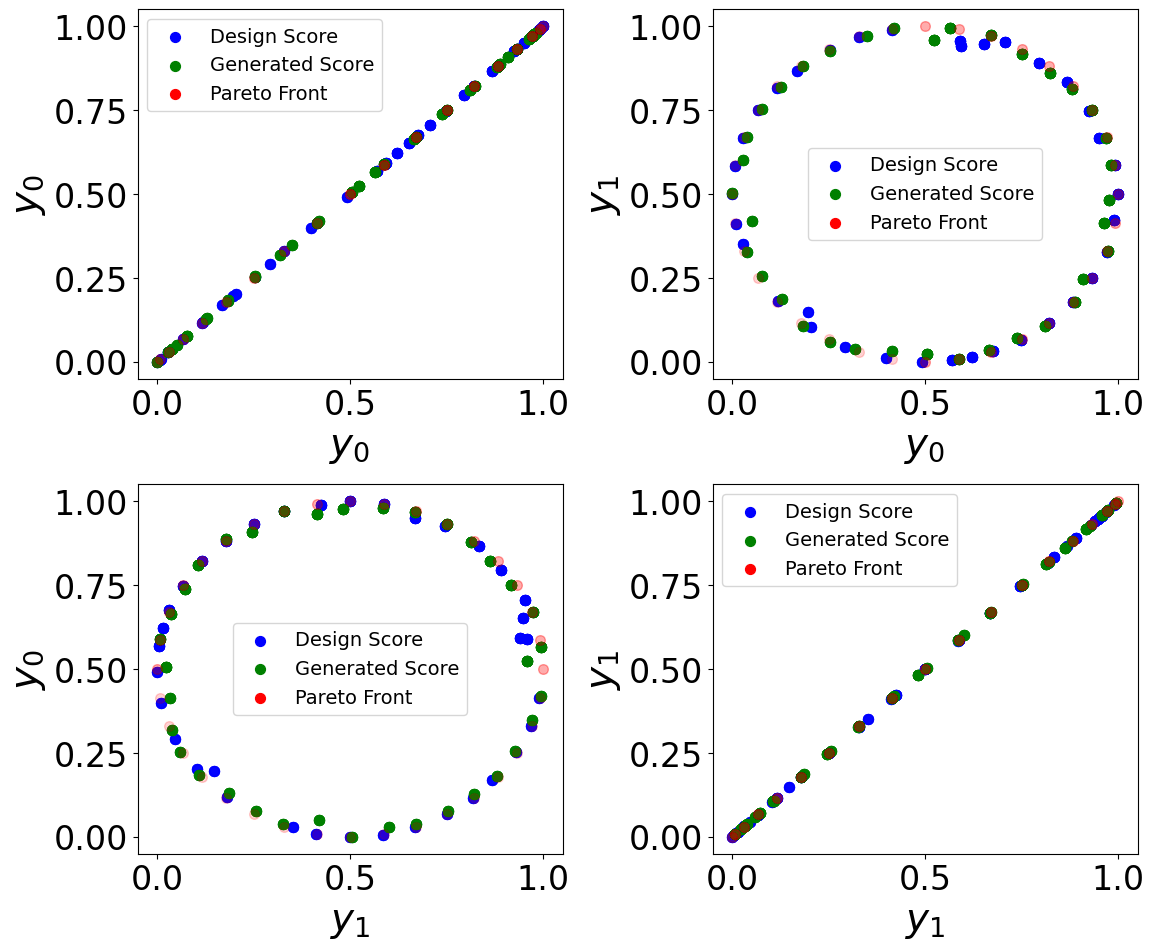

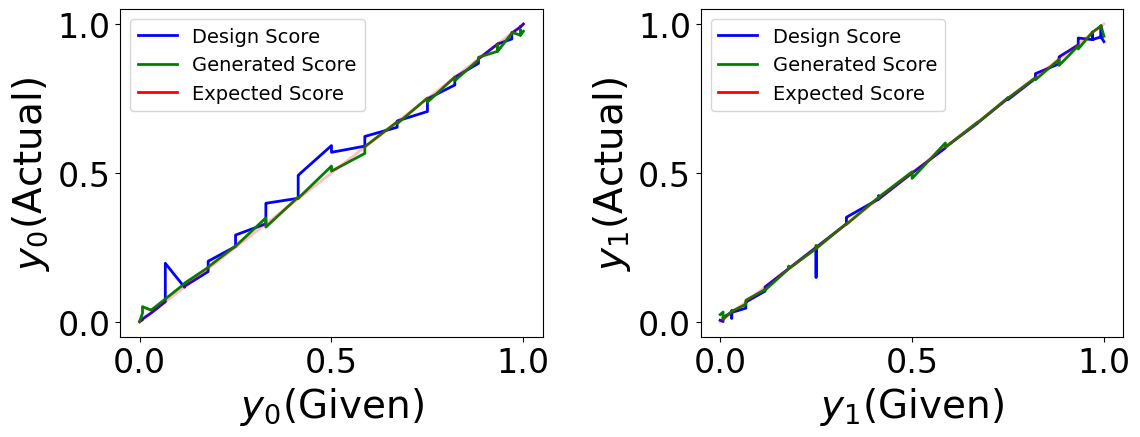

Hypervolume (100th): 4.763755
Hypervolume (D(best)): 13.264787
Ideal Hypervolume: 4.840578
y_given Hypervolume: 4.774988
pf Hypervolume: 4.774988
GD: 0.014616534491638012
GD+: 0.0013954263147721655
IGD: 0.01676055847467018
IGD+: 0.002943322314075923
L2 dist between design score and given y: 0.8483623155588096
L2 dist between generated and given y: 0.31239430082864483
Spread for y_cand: 1.795495304845812
Spread for y_gen: 1.788283587976515
****************************************Seed: 42*********************************************************


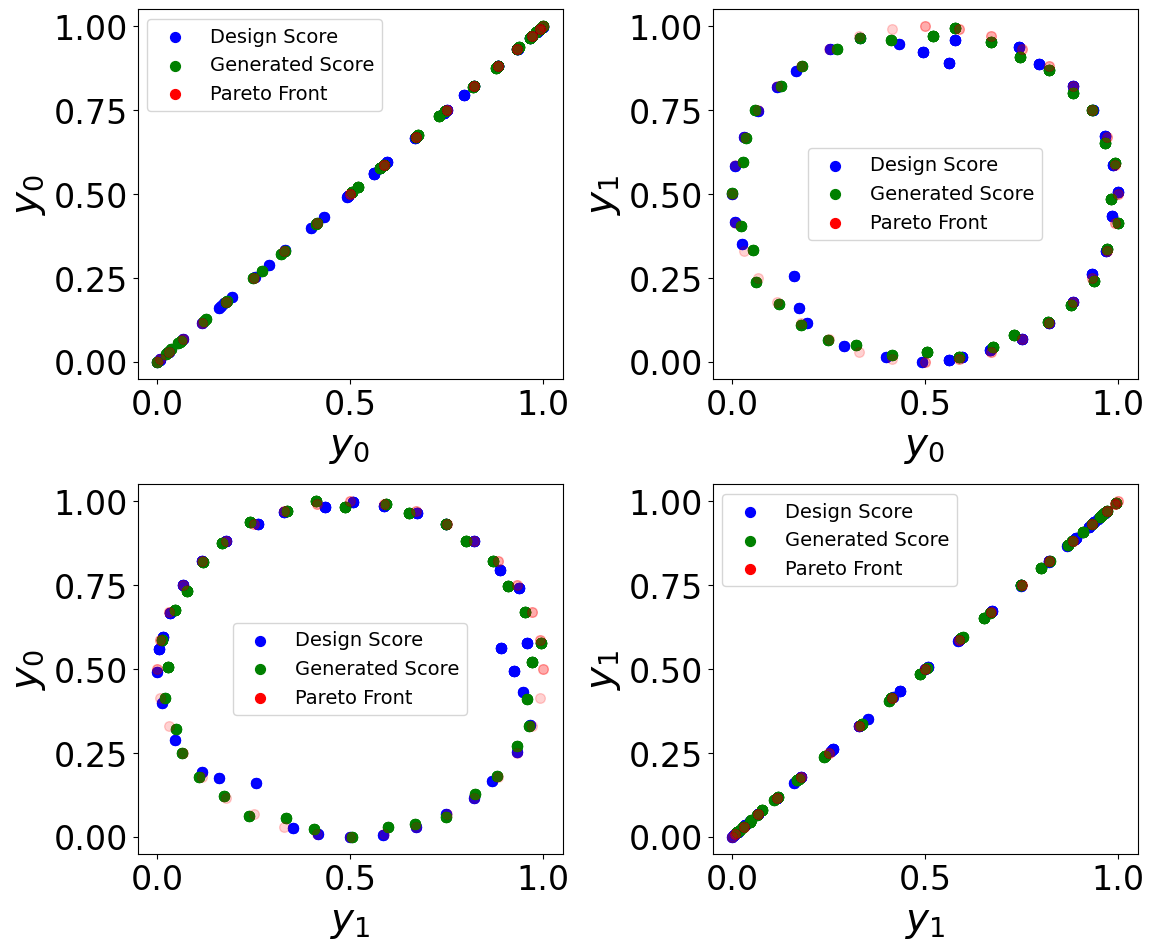

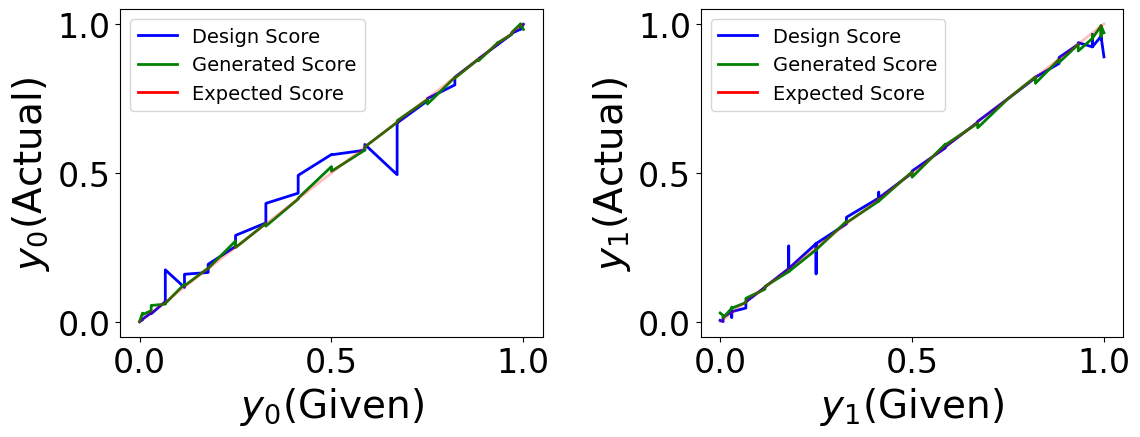

Hypervolume (100th): 4.755646
Hypervolume (D(best)): 13.264787
Ideal Hypervolume: 4.840578
y_given Hypervolume: 4.774988
pf Hypervolume: 4.774988
GD: 0.018721589119333366
GD+: 0.0006713422903544193
IGD: 0.01813292652072992
IGD+: 0.004627142497016141
L2 dist between design score and given y: 0.9822001447204515
L2 dist between generated and given y: 0.31802066749024904
Spread for y_cand: 1.7877833046786153
Spread for y_gen: 1.7880819684070046
****************************************Seed: 43*********************************************************


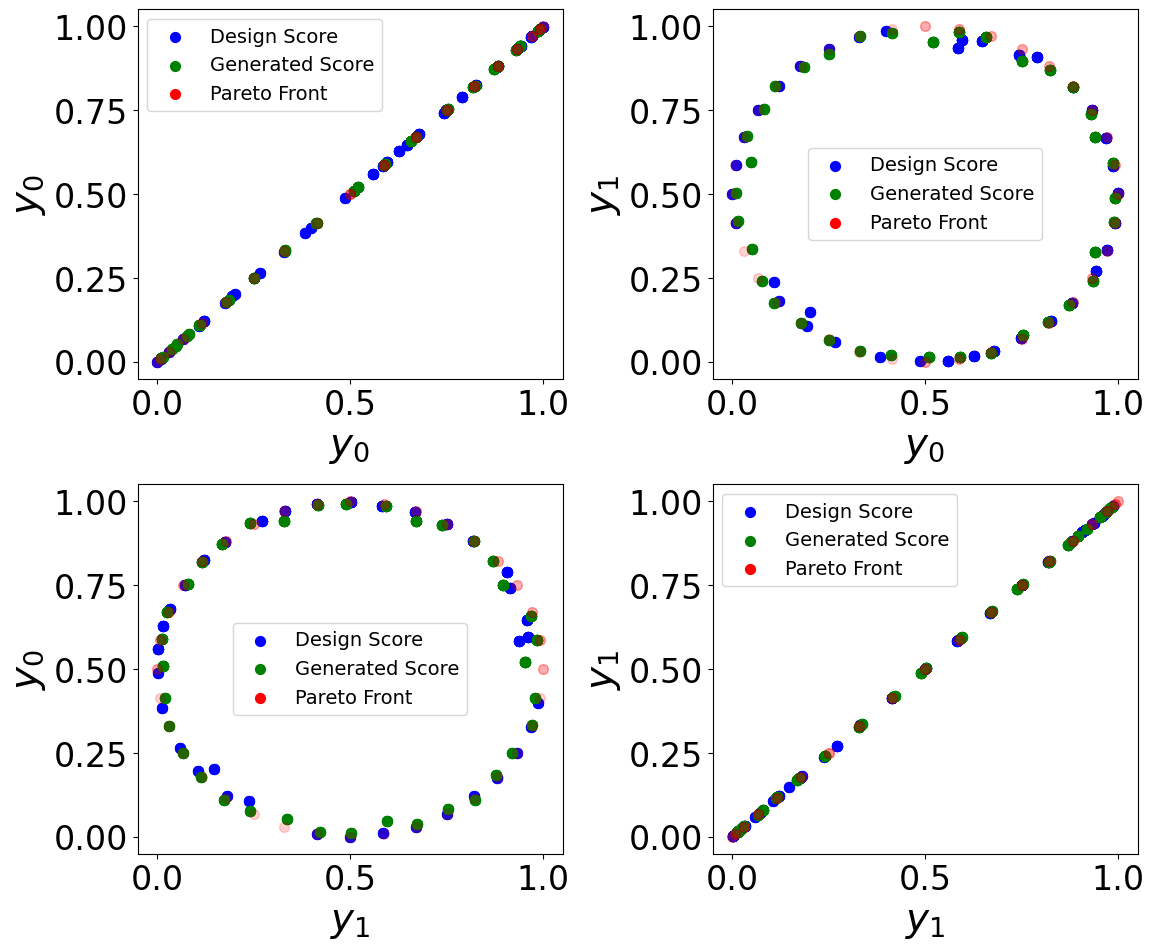

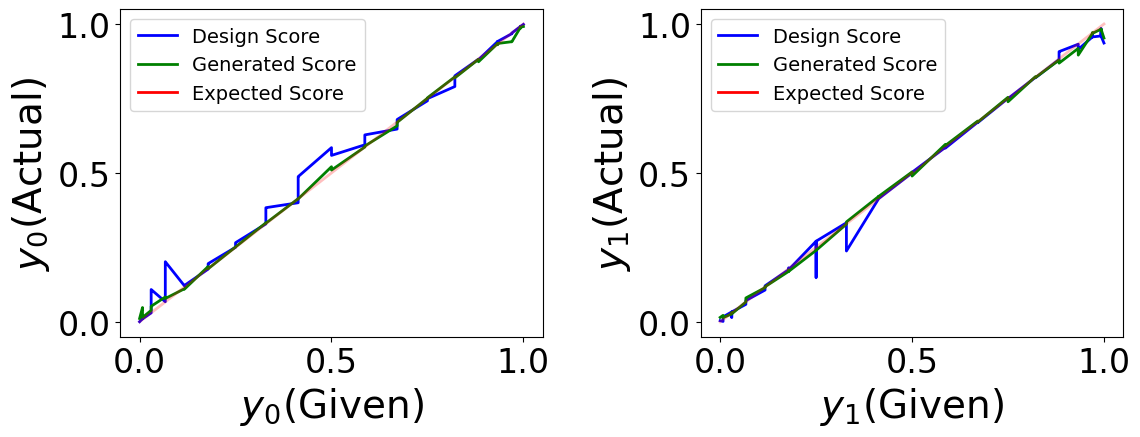

Hypervolume (100th): 4.759356
Hypervolume (D(best)): 13.264787
Ideal Hypervolume: 4.840578
y_given Hypervolume: 4.774988
pf Hypervolume: 4.774988
GD: 0.01505396079076224
GD+: 0.0009548647521512884
IGD: 0.0173056343247303
IGD+: 0.0036203281307185704
L2 dist between design score and given y: 0.8654681900167913
L2 dist between generated and given y: 0.311803338162961
Spread for y_cand: 1.7918313808193393
Spread for y_gen: 1.7927845611693236


In [10]:
#This cell is to conduct conditional generation  with k = 256
if config['augment']:
    pf = task.problem.get_pareto_front() 
    if config['normalize_ys']:
        pf = task.normalize_y(pf)
    y_min = np.minimum(y_min, pf.min(axis=0))
    y_max = np.maximum(y_max, pf.max(axis=0))
    clip_min = torch.tensor(np.concatenate((x_min, y_min)))#x_lbound
    clip_max = torch.tensor(np.concatenate((x_max, y_max)))#x_ubound
else:
    clip_min = torch.tensor(x_min)
    clip_max = torch.tensor(x_max)
print(clip_dic)

config['simple_clip'] = True
# clip_min = - torch.ones_like(clip_min)*0.1
clip_dic = {'simple_clip': config['simple_clip'], 'clip_min': clip_min , 'clip_max': clip_max}
print(clip_dic)

# y_given_list  = np.linspace(0.1, 15, 100)
with fixed_random_seed(1000):
    if len(pf)<1000:
        rand_idx = list(range(len(pf)))
    else:
        rand_idx = np.random.choice(len(pf), 1000, replace=False)
y_given_list =  pf[rand_idx]
num_samples = 1000

num_steps = 200
inference_scaling_bool = True
duplicated_time = 64
description = 'resampling_fks'
kkk=256

seed_list = [40, 41, 42, 43]
HV_list = []
IGD_list = []

import pickle

for seed in seed_list:
    print(f"****************************************Seed: {seed}*********************************************************")
    xy_pred = {f'{n}': None for n in range(num_samples)}
    xy_scores = {f'{n}': None for n in range(num_samples)}

    all_res = {"y_given_list":y_given_list}
    all_res['denoising_step'] = num_steps
    all_res['inference_scaling_bool'] = inference_scaling_bool
    all_res['duplicated_time'] = duplicated_time
    all_res['shot_num'] = kkk 
    all_res.update(clip_dic)

    for i in y_given_list:
        y_given = torch.tensor(i) 
        res = mango_eval(
            task=task,
            forwardmodel=model,
            inverse_model=inverse_model,
            # hidden_size=config['hidden_size'],
            device='auto',
            num_samples= config['num_solutions'],
            seed=seed,
            logging_dir=logging_dir,
            ckpt_dir=config['model_save_dir'],
            augment=config['augment'],
            clip_dic=clip_dic,
            gamma=0,
            gen_condition=y_given,
            guidance=True,
            num_steps=num_steps,
            inference_scaling_bool=inference_scaling_bool,
            duplicated_time=duplicated_time,
        )
        for num_samples1 in range(res['x'].shape[0]):
            if xy_pred[f'{num_samples1}'] is None:
                xy_pred[f'{num_samples1}'] = res['x'][num_samples1]
                # xy_scores[f'{num_samples}'] = res['y_scores'][num_samples]
            else:
                xy_pred[f'{num_samples1}'] = np.vstack((xy_pred[f'{num_samples1}'], res['x'][num_samples1]))
                # xy_scores[f'{num_samples}'] = np.vstack((xy_scores[f'{num_samples}'], res['y_scores'][num_samples]))

        all_res[f'y_given_{i}'] = res

    #save all_res
    file_path = os.path.join(logging_dir, f"cond_{description}_all_res_shot{kkk}_seed{seed}.pkl")
    with open(file_path, 'wb') as f:
        pickle.dump(all_res, f)

    #get best result
    x_opt_cand, y_cand, y_gen, valid_num = get_best_result(task, res, xy_pred, y_given_list, clip_max, clip_min, kkk, config)

    np.save(f'{logging_dir}/cond_{description}_res_x_opt_cand_shot{kkk}_seed{seed}.npy', x_opt_cand)
    np.save(f'{logging_dir}/cond_{description}_res_y_cand_shot{kkk}_seed{seed}.npy', y_cand)
    np.save(f'{logging_dir}/cond_{description}_res_y_gen_shot{kkk}_seed{seed}.npy', y_gen)
 

    #plot scatterr
    plot_scatter(y_cand, y_gen, y_given_list, description, logging_dir, kkk, seed)
    #plot line
    plot_line(y_cand, y_gen, y_given_list, description, logging_dir, kkk, seed)
    #save indicators
    save_indicators(HV_list, IGD_list, y_cand, y_gen, y_given_list, pf, description, logging_dir, kkk, seed, config, task)

In [11]:
print(f"Average Hypervolume: {np.mean(HV_list):.4f} ± {np.std(HV_list):.4f}")
print(f"Average IGD: {np.mean(IGD_list):.4f} ± {np.std(IGD_list):.4f}")

Average Hypervolume: 4.7574 ± 0.0048
Average IGD: 0.0166 ± 0.0014


{'simple_clip': True, 'clip_min': tensor([ 0.0000e+00,  0.0000e+00, -1.1199e-06, -2.0013e-06],
       dtype=torch.float64), 'clip_max': tensor([1.0000, 1.0000, 1.0001, 1.0000], dtype=torch.float64)}
{'simple_clip': True, 'clip_min': tensor([ 0.0000e+00,  0.0000e+00, -1.1199e-06, -2.0013e-06],
       dtype=torch.float64), 'clip_max': tensor([1.0000, 1.0000, 1.0001, 1.0000], dtype=torch.float64)}
****************************************Seed: 40*********************************************************


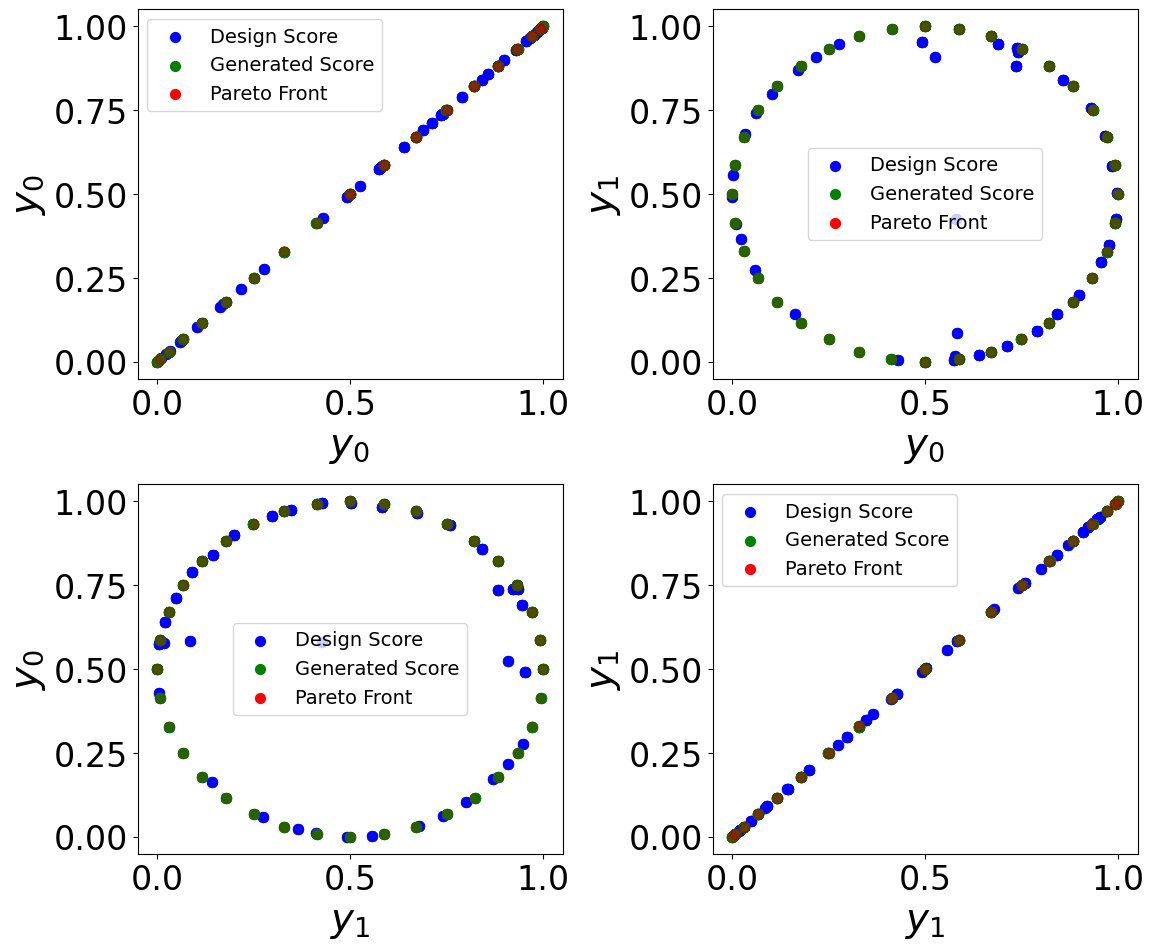

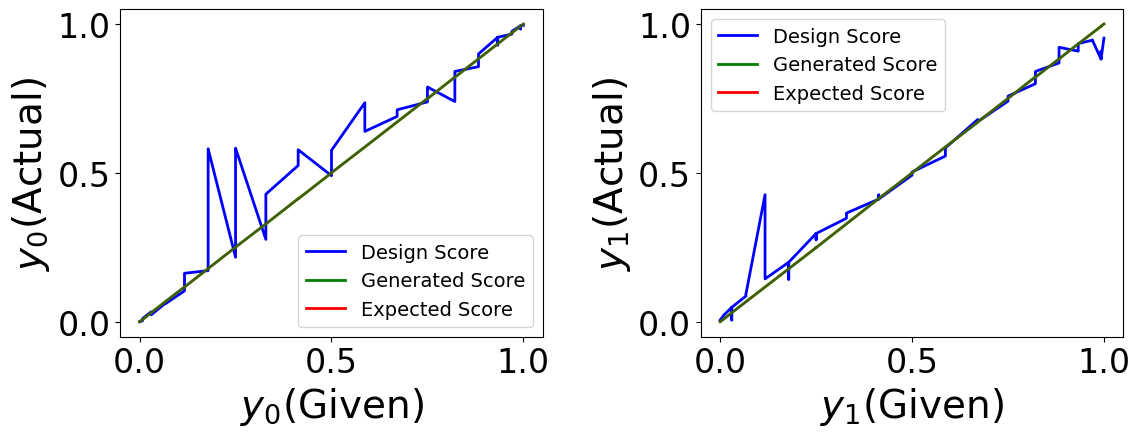

Hypervolume (100th): 4.740025
Hypervolume (D(best)): 13.264787
Ideal Hypervolume: 4.840578
y_given Hypervolume: 4.774988
pf Hypervolume: 4.774988
GD: 0.032978028326833456
GD+: 0.0016417282915350425
IGD: 0.03434934796213897
IGD+: 0.006015683859804099
L2 dist between design score and given y: 1.998704107784805
L2 dist between generated and given y: 0.010071270723942406
Spread for y_cand: 1.7733191297451558
Spread for y_gen: 1.7850864662897383
****************************************Seed: 41*********************************************************


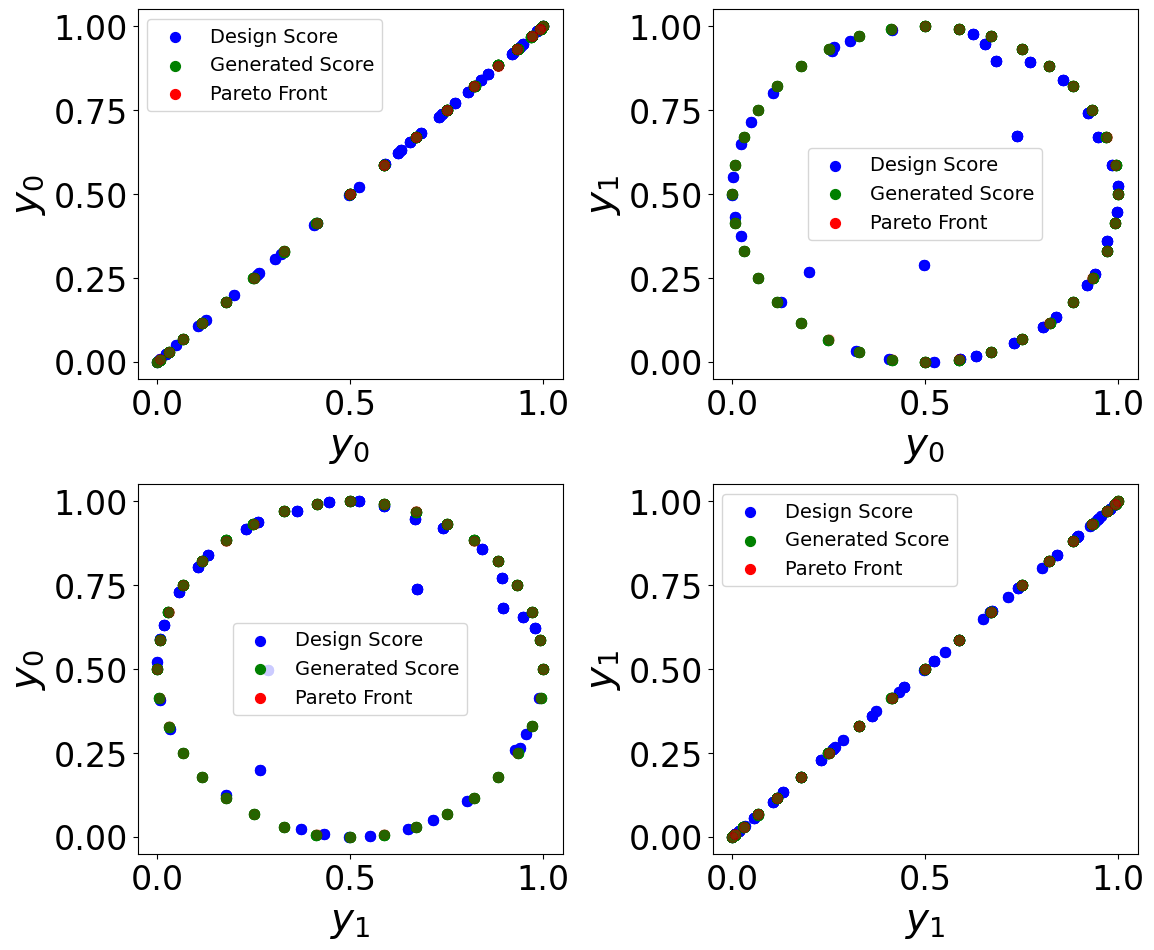

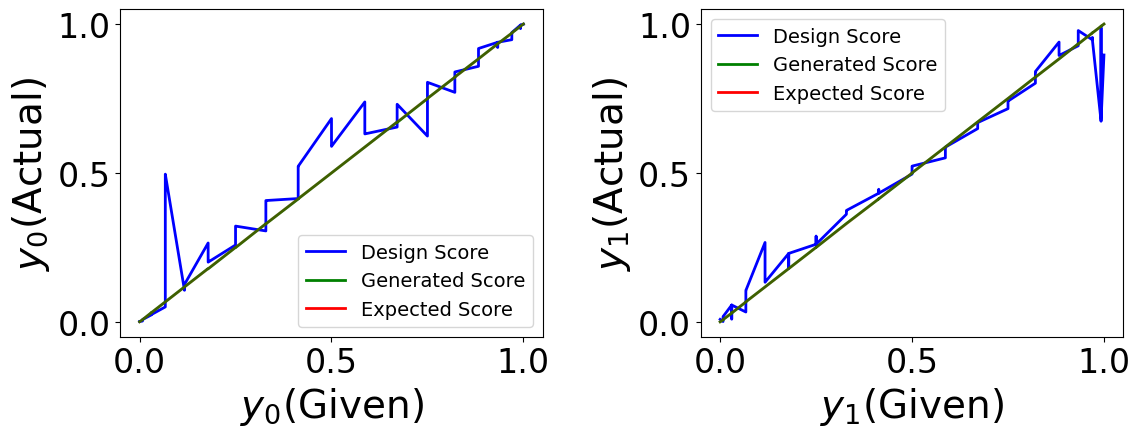

Hypervolume (100th): 4.749372
Hypervolume (D(best)): 13.264787
Ideal Hypervolume: 4.840578
y_given Hypervolume: 4.774988
pf Hypervolume: 4.774988
GD: 0.03837364344492362
GD+: 0.0016465211383419913
IGD: 0.03262514754697885
IGD+: 0.005174886746370989
L2 dist between design score and given y: 2.0582341770372223
L2 dist between generated and given y: 0.010732797623923047
Spread for y_cand: 1.7739179608372306
Spread for y_gen: 1.7910561710103008
****************************************Seed: 42*********************************************************


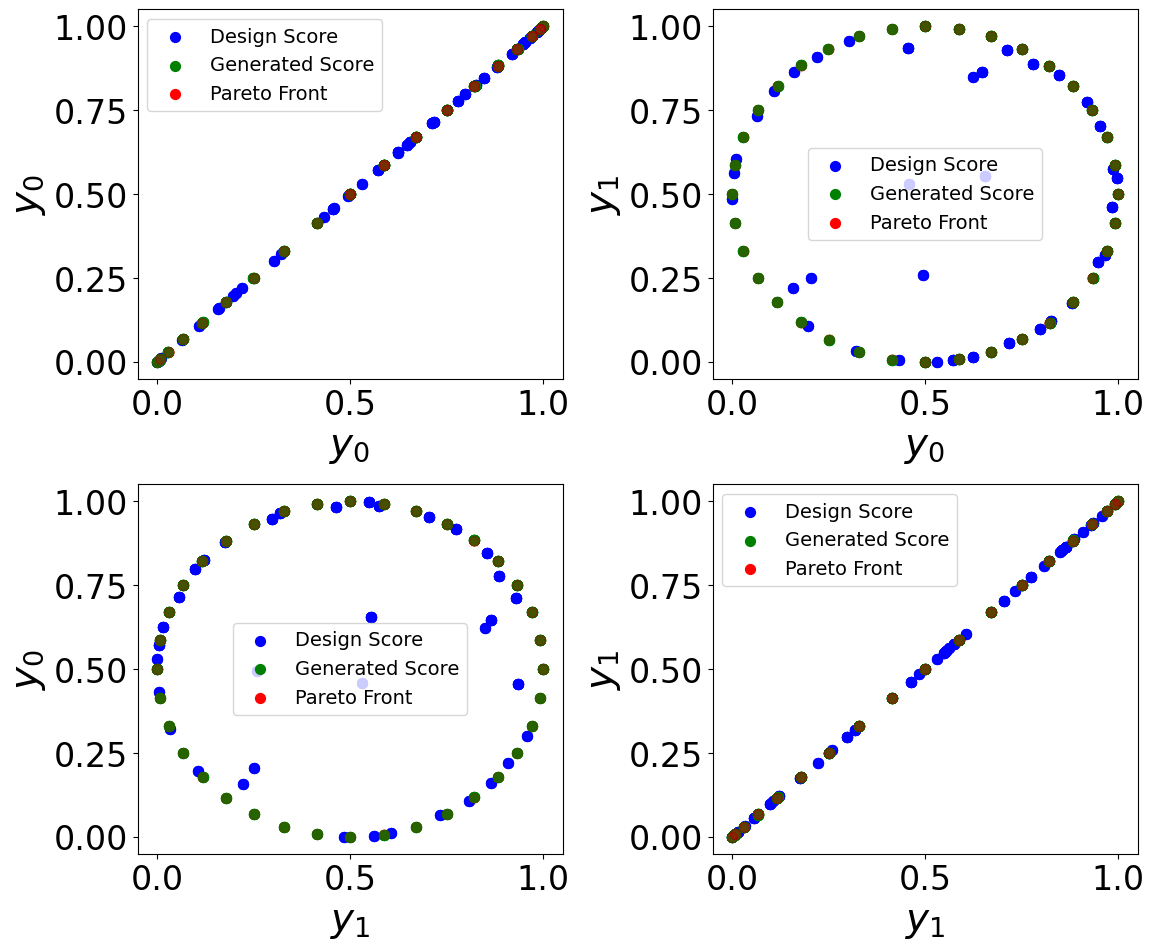

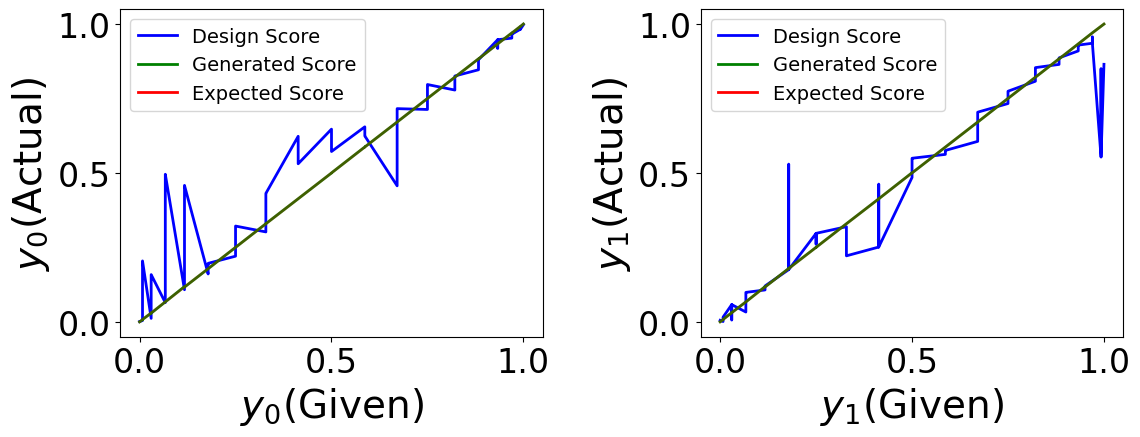

Hypervolume (100th): 4.734392
Hypervolume (D(best)): 13.264787
Ideal Hypervolume: 4.840578
y_given Hypervolume: 4.774988
pf Hypervolume: 4.774988
GD: 0.058514829260321054
GD+: 0.0028001102505892826
IGD: 0.04263903555733589
IGD+: 0.008050723760552284
L2 dist between design score and given y: 2.4408607080939135
L2 dist between generated and given y: 0.009630262757594614
Spread for y_cand: 1.7772446846726164
Spread for y_gen: 1.7736885578058368
****************************************Seed: 43*********************************************************


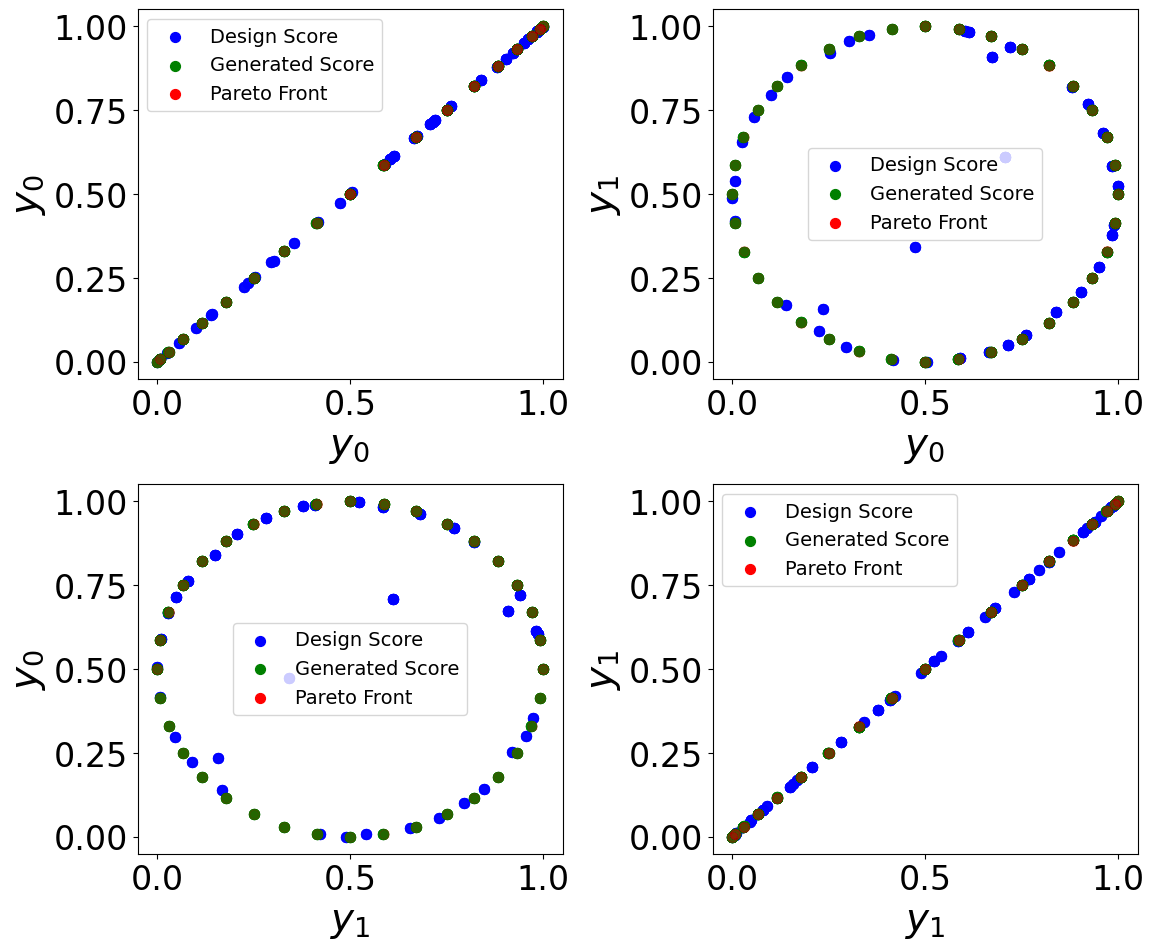

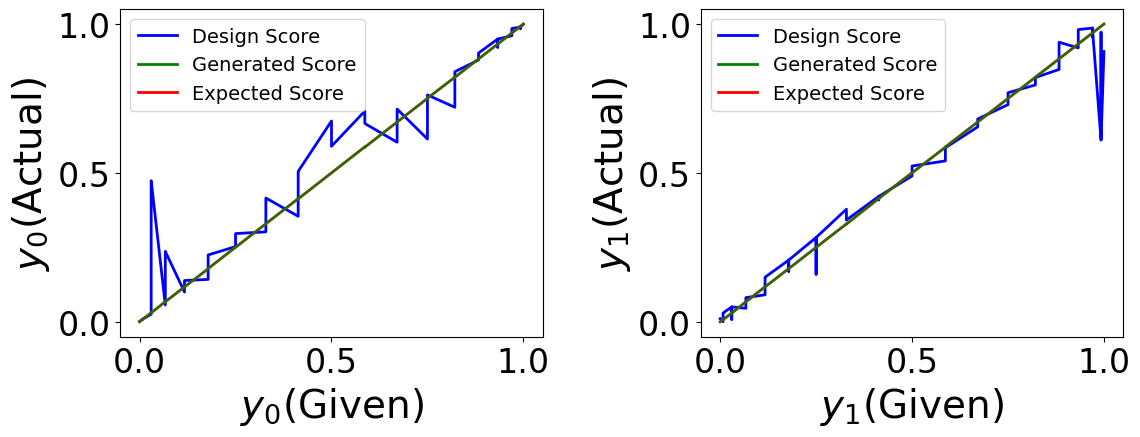

Hypervolume (100th): 4.751920
Hypervolume (D(best)): 13.264787
Ideal Hypervolume: 4.840578
y_given Hypervolume: 4.774988
pf Hypervolume: 4.774988
GD: 0.038877879959271396
GD+: 0.002520834794260749
IGD: 0.032213140828024324
IGD+: 0.005326991652787235
L2 dist between design score and given y: 2.236868832847917
L2 dist between generated and given y: 0.01004442987004055
Spread for y_cand: 1.7808008379928442
Spread for y_gen: 1.789874212705577


In [12]:
#This cell is to conduct conditional generation  with k = 1
if config['augment']:
    pf = task.problem.get_pareto_front() 
    if config['normalize_ys']:
        pf = task.normalize_y(pf)
    y_min = np.minimum(y_min, pf.min(axis=0))
    y_max = np.maximum(y_max, pf.max(axis=0))
    clip_min = torch.tensor(np.concatenate((x_min, y_min)))#x_lbound
    clip_max = torch.tensor(np.concatenate((x_max, y_max)))#x_ubound
else:
    clip_min = torch.tensor(x_min)
    clip_max = torch.tensor(x_max)
print(clip_dic)

config['simple_clip'] = True
# clip_min = - torch.ones_like(clip_min)*0.1
clip_dic = {'simple_clip': config['simple_clip'], 'clip_min': clip_min , 'clip_max': clip_max}
print(clip_dic)

# y_given_list  = np.linspace(0.1, 15, 100)
with fixed_random_seed(1000):
    if len(pf)<1000:
        rand_idx = list(range(len(pf)))
    else:
        rand_idx = np.random.choice(len(pf), 1000, replace=False)
y_given_list =  pf[rand_idx]
num_samples = 1000

num_steps = 200
inference_scaling_bool = True
duplicated_time = 64
description = 'resampling_fks'
kkk=1

seed_list = [40, 41, 42, 43]
HV_list = []
IGD_list = []

import pickle

for seed in seed_list:
    print(f"****************************************Seed: {seed}*********************************************************")
    xy_pred = {f'{n}': None for n in range(num_samples)}
    xy_scores = {f'{n}': None for n in range(num_samples)}

    all_res = {"y_given_list":y_given_list}
    all_res['denoising_step'] = num_steps
    all_res['inference_scaling_bool'] = inference_scaling_bool
    all_res['duplicated_time'] = duplicated_time
    all_res['shot_num'] = kkk 
    all_res.update(clip_dic)

    for i in y_given_list:
        y_given = torch.tensor(i) 
        res = mango_eval(
            task=task,
            forwardmodel=model,
            inverse_model=inverse_model,
            # hidden_size=config['hidden_size'],
            device='auto',
            num_samples= config['num_solutions'],
            seed=seed,
            logging_dir=logging_dir,
            ckpt_dir=config['model_save_dir'],
            augment=config['augment'],
            clip_dic=clip_dic,
            gamma=0,
            gen_condition=y_given,
            guidance=True,
            num_steps=num_steps,
            inference_scaling_bool=inference_scaling_bool,
            duplicated_time=duplicated_time,
        )
        for num_samples1 in range(res['x'].shape[0]):
            if xy_pred[f'{num_samples1}'] is None:
                xy_pred[f'{num_samples1}'] = res['x'][num_samples1]
                # xy_scores[f'{num_samples}'] = res['y_scores'][num_samples]
            else:
                xy_pred[f'{num_samples1}'] = np.vstack((xy_pred[f'{num_samples1}'], res['x'][num_samples1]))
                # xy_scores[f'{num_samples}'] = np.vstack((xy_scores[f'{num_samples}'], res['y_scores'][num_samples]))

        all_res[f'y_given_{i}'] = res

    #save all_res
    file_path = os.path.join(logging_dir, f"cond_{description}_all_res_shot{kkk}_seed{seed}.pkl")
    with open(file_path, 'wb') as f:
        pickle.dump(all_res, f)

    #get best result
    x_opt_cand, y_cand, y_gen, valid_num = get_best_result(task, res, xy_pred, y_given_list, clip_max, clip_min, kkk, config)

    np.save(f'{logging_dir}/cond_{description}_res_x_opt_cand_shot{kkk}_seed{seed}.npy', x_opt_cand)
    np.save(f'{logging_dir}/cond_{description}_res_y_cand_shot{kkk}_seed{seed}.npy', y_cand)
    np.save(f'{logging_dir}/cond_{description}_res_y_gen_shot{kkk}_seed{seed}.npy', y_gen)
 

    #plot scatterr
    plot_scatter(y_cand, y_gen, y_given_list, description, logging_dir, kkk, seed)
    #plot line
    plot_line(y_cand, y_gen, y_given_list, description, logging_dir, kkk, seed)
    #save indicators
    save_indicators(HV_list, IGD_list, y_cand, y_gen, y_given_list, pf, description, logging_dir, kkk, seed, config, task)

In [13]:
print(f"Average Hypervolume: {np.mean(HV_list):.4f} ± {np.std(HV_list):.4f}")
print(f"Average IGD: {np.mean(IGD_list):.4f} ± {np.std(IGD_list):.4f}")

Average Hypervolume: 4.7439 ± 0.0071
Average IGD: 0.0355 ± 0.0042
